In [1]:
## importing required libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split

In [2]:
## reading test and train datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
print(train.shape)
print(test.shape)

(567730, 83)
(243313, 82)


Training dataset contains 567730 rows(records) and 83 columns(features)

In [4]:
train['HasDetections'].value_counts()

0    482571
1     85159
Name: HasDetections, dtype: int64

#### This is a binary classification problem. But this is an imbalanced dataset based on count of target 'HasDetections'. There are more no of values of '0 class' than '1 class' . approx -> (1:6 ratio)

In [4]:
machine_id = test['MachineIdentifier']

In [6]:
## datatypes and no of missing values in each feature column
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567730 entries, 0 to 567729
Data columns (total 83 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   MachineIdentifier                                  567730 non-null  object 
 1   ProductName                                        567730 non-null  object 
 2   EngineVersion                                      567730 non-null  object 
 3   AppVersion                                         567730 non-null  object 
 4   AvSigVersion                                       567730 non-null  object 
 5   IsBeta                                             567730 non-null  int64  
 6   RtpStateBitfield                                   565573 non-null  float64
 7   IsSxsPassiveMode                                   567730 non-null  int64  
 8   DefaultBrowsersIdentifier                          29528 non-null   float6

Train dataset has 83 columns, among which "HasDetections" is target column. There are 30 columns with categorical data (non-numerical)

#### Missing Values Handling

About 44 features have missing values in them. we shall perform missing data analysis for each type of datatype seperately 

In [7]:
## missing value counts of categorical(object) types
a = train.dtypes[train.dtypes == 'object'].index
(train[a].isna().sum()/train.shape[0]).sort_values(ascending=False).head(10)

PuaMode                         0.999813
Census_ProcessorClass           0.996121
Census_InternalBatteryType      0.704557
SmartScreen                     0.365272
Census_PrimaryDiskTypeName      0.001457
Census_ChassisTypeName          0.000070
Census_PowerPlatformRoleName    0.000009
OsBuildLab                      0.000002
SkuEdition                      0.000000
Census_FlightRing               0.000000
dtype: float64

There are 8 columns of object dtype with missing values. "PuaMode" feature being with highest with almost 99% missing values.

In [8]:
## missing value counts of float types
b = train.dtypes[train.dtypes == 'float'].index
(train[b].isna().sum()/train.shape[0]).sort_values(ascending=False)

DefaultBrowsersIdentifier                            0.947989
Census_IsFlightingInternal                           0.827571
Census_ThresholdOptIn                                0.631275
Census_IsWIMBootEnabled                              0.630317
OrganizationIdentifier                               0.309818
SMode                                                0.067842
CityIdentifier                                       0.036826
Wdft_IsGamer                                         0.033347
Wdft_RegionIdentifier                                0.033347
Census_InternalBatteryNumberOfCharges                0.028239
Census_FirmwareManufacturerIdentifier                0.022759
Census_FirmwareVersionIdentifier                     0.019884
Census_IsFlightsDisabled                             0.017480
Census_OEMModelIdentifier                            0.011865
Census_OEMNameIdentifier                             0.011111
Firewall                                             0.010184
Census_T

There are 50 columns of float dtype having missing values. "DefaultBrowsersIdentifier" feature being with highest = 94.7% and "GeoNameIdentifier" with lowest -> 0.0032%

In [9]:
## missing value counts of int types
c = train.dtypes[train.dtypes == 'int64'].index
train[c].isna().sum().sort_values(ascending=False).head()

HasDetections        0
AutoSampleOptIn      0
IsSxsPassiveMode     0
HasTpm               0
CountryIdentifier    0
dtype: int64

As we can see, columns with int dtypes having no missing values. So we only have to deal with columns of object and float datatypes.

For these features, we shall fill mode value for missing values for these columns. The reasoning is that people use computer parts that are most popular / or used by majority people.

In [5]:
## function for filling missing values with mode values of respective columns
def handle_missing_values(train,test): 
    for feature in ["DefaultBrowsersIdentifier","Census_IsFlightingInternal", "Census_ThresholdOptIn", "Census_IsWIMBootEnabled", "OrganizationIdentifier",
                "SMode", "Wdft_IsGamer", "Wdft_RegionIdentifier", "Census_FirmwareManufacturerIdentifier", "Census_FirmwareVersionIdentifier", 
                "Census_OEMModelIdentifier", "Census_OEMNameIdentifier", "Firewall", "Census_TotalPhysicalRAM", "Census_IsAlwaysOnAlwaysConnectedCapable",
                "Census_OSInstallLanguageIdentifier", "IeVerIdentifier", "Census_SystemVolumeTotalCapacity", "Census_PrimaryDiskTotalCapacity",
                "Census_InternalPrimaryDiagonalDisplaySizeInInches", "Census_InternalPrimaryDisplayResolutionHorizontal", 
                "Census_InternalPrimaryDisplayResolutionVertical", "AVProductsEnabled", "AVProductsInstalled", "AVProductStatesIdentifier", "IsProtected", 
                "Census_ProcessorModelIdentifier", "Census_ProcessorCoreCount", "Census_ProcessorManufacturerIdentifier", "RtpStateBitfield", 
                "Census_IsVirtualDevice", "UacLuaenable", "GeoNameIdentifier",'SmartScreen', 'Census_PrimaryDiskTypeName', 'Census_ChassisTypeName', 
                'Census_PowerPlatformRoleName', 'OsBuildLab']:
        
        train[feature].fillna(train[feature].mode()[0], inplace=True)
        test[feature].fillna(test[feature].mode()[0], inplace=True)
                
    return train,test

In [6]:
train, test = handle_missing_values(train, test)

Because of the presence of vague values in Battery_type_column, & for the sake of simplicity, lets club other than lion batteries into another value - 'non-lion' since most modern batteries are lithium lion based. This will also eventually fill the missing values.

In [7]:
## filling values with lion as 1 as others as 0, same change reflected in test dataset
def filter_batteries(bat):
    bat = str(bat)
    if 'li' in bat:
        return 1
    else:
        return 0

train["Census_InternalBatteryType"] = train["Census_InternalBatteryType"].apply(filter_batteries)
test["Census_InternalBatteryType"] = test["Census_InternalBatteryType"].apply(filter_batteries)

In [13]:
train['SmartScreen'].value_counts()

RequireAdmin    506312
ExistsNotSet     37910
Off              11932
Warn              7676
Prompt            2288
Block             1432
off                 75
On                  52
&#x02;              26
&#x01;              15
on                   9
OFF                  2
requireadmin         1
Name: SmartScreen, dtype: int64

Similar situation arises in Smart_Screen feature, but here the values are repeated in different form of words, so we need to clean whichever have special chars and convert similar words to single root form

In [8]:
conversion_dict = {
    'off': 'Off', '&#x02;': '2', '&#x01;': '1', 'on': 'On', 'requireadmin': 'RequireAdmin', 'OFF': 'Off', 
    'Promt': 'Prompt', 'requireAdmin': 'RequireAdmin', 'prompt': 'Prompt', 'warn': 'Warn', 
    '00000000': '0', '&#x03;': '3', np.nan: 'NoExist'
}
train.replace({'SmartScreen': conversion_dict}, inplace=True)
test.replace({'SmartScreen': conversion_dict}, inplace=True)

### EDA Analysis

#### Univariate Analysis

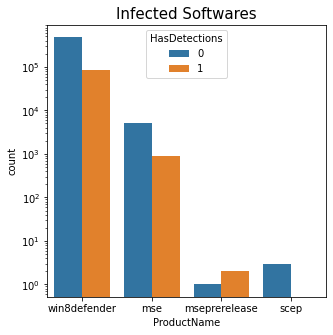

In [15]:
## Antivirus Product name vs Detection target

plt.figure(figsize = (5,5))
sns.countplot(x='ProductName', hue='HasDetections', data = train)
plt.yscale('log')
plt.title('Infected Softwares', size=15)
plt.show()

Lot of people use win8defender and mse detection softwares. Both of them seem to have same ratio of no_detection/detection. Msepre-release seems to perform worse as expected since its just a pre-release software. scep software has no detection data, bu we can't conclude on it because size of samples for it is very less.

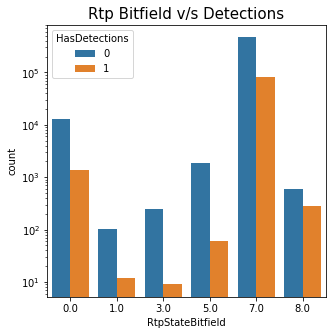

In [16]:
## Rtp State Bitfield v/s Target Detection (Rtp -->  a network transport protocol)
plt.figure(figsize = (5,5))
sns.countplot(x='RtpStateBitfield', hue='HasDetections', data = train)
plt.yscale('log')
plt.title('Rtp Bitfield v/s Detections', size=15)
plt.show()

Lot of machines have bitfield set as '7'. But from this histograph, it seems bitfield 1, 3, 5 seems to perform better wrt detections the machine has.

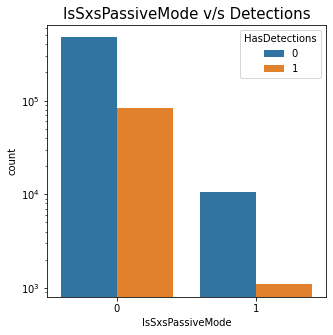

In [17]:
## SXS Passive Mode v/s Detections
plt.figure(figsize = (5,5))
sns.countplot(x='IsSxsPassiveMode', hue='HasDetections', data = train)
plt.yscale('log')
plt.title('IsSxsPassiveMode v/s Detections', size=15)
plt.show()

Passive Mode set to 1 seems to have better defence against detection, but then again due to less no of systems having mode = 1, we can't conclude.

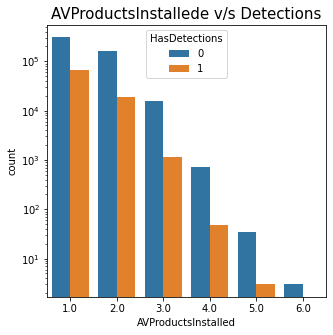

In [18]:
## No of AV Products installed v/s Detections
plt.figure(figsize = (5,5))
sns.countplot(x='AVProductsInstalled', hue='HasDetections', data = train)
plt.yscale('log')
plt.title('AVProductsInstalled v/s Detections', size=15)
plt.show()

From the above graph, it looks like the more AV Products are installed the better is the defence against malwares. But for this to conculde, we should consider whether all of them are enabled or not.

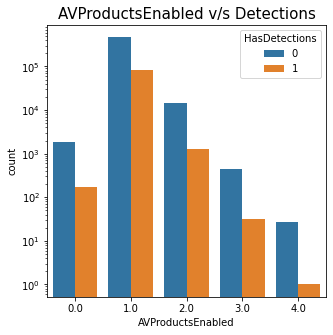

In [19]:
## No of AV Products enabled v/s Detections
plt.figure(figsize = (5,5))
sns.countplot(x='AVProductsEnabled', hue='HasDetections', data = train)
plt.yscale('log')
plt.title('AVProductsEnabled v/s Detections', size=15)
plt.show()

It looks as if when 4 AVProducts are enabled, the system seem to have better defence. 

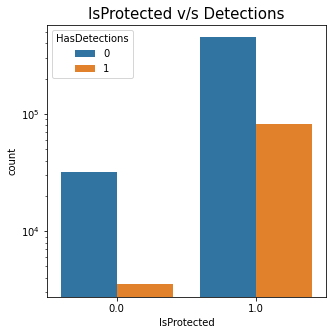

In [20]:
## IsProtected v/s Detections
plt.figure(figsize = (5,5))
sns.countplot(x='IsProtected', hue='HasDetections', data = train)
plt.yscale('log')
plt.title('IsProtected v/s Detections', size=15)
plt.show()

Assuming this feature is cummulative of info on AV Products Enabled, Virus defintion etc. The graph goes against common intitution that it seems to have less detections when protection is turned off.

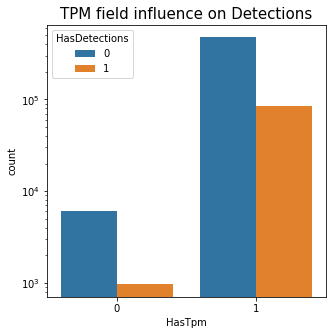

In [21]:
## TPM v/s Detections
plt.figure(figsize = (5,5))
sns.countplot(x='HasTpm', hue='HasDetections', data = train)
plt.yscale('log')
plt.title('TPM field influence on Detections', size=15)
plt.show()

From the above graph, there's not much difference in ratios of detections in both cases, but it detections are slightly less when Tpm is 0 compared to when its set to 1. 

#### Does Location of user has impact on No of Detections?

There are several features pertaining location of user/system -> <br> Country_Identifier, City_identifier, Geo_Name, Orgianization_Identifier, Locale_English_name, Region_identifier. 

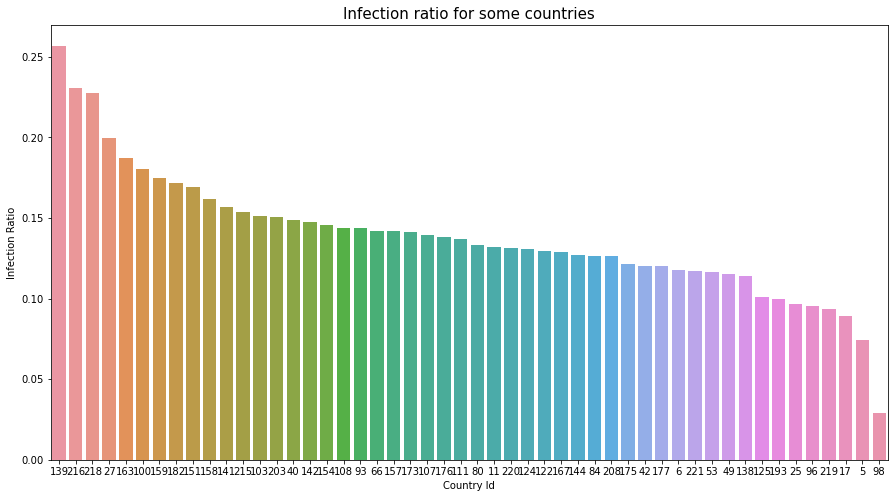

In [22]:
ratios = {}
for c in train['CountryIdentifier'].unique():
    df = train[train['CountryIdentifier'] == c]
    ratios[c] = sum(df['HasDetections']) / len(df)

data = pd.DataFrame({"Country Id": list(ratios.keys()), "Infection Ratio": list(ratios.values())}).sample(50).sort_values(by='Infection Ratio')
order = list(data['Country Id'])[::-1]

plt.figure(figsize=(15,8))
sns.barplot(x="Country Id", y="Infection Ratio", data=data, order=order)
plt.title('Infection ratio for some countries', size=15)
plt.show()

Since the country_ids are numerical, we can't interpret much about them. But from above graph we can conculde that country_id with 13 has highest infection ration, and country_id with 98 being with least.

So, location of user/system may play a role in predicting infections, since some countries may be underdevloped and hence have older systems, 
which are more prone to malware attacks. It can also be reasoned that rich countries invest more in cybersecurity, and hence have better defence against malwares.

#### Influence of choice of Operating system on infections

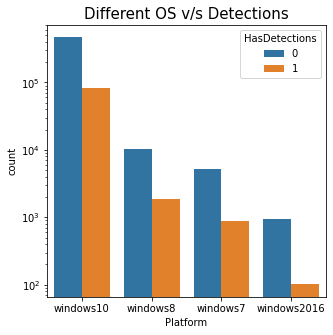

In [23]:
## OS v/s Detections
plt.figure(figsize = (5,5))
sns.countplot(x='Platform', hue='HasDetections', data = train)
plt.yscale('log')
plt.title('Different OS v/s Detections', size=15)
plt.show()

Windows 2016 seems to have better infection ratio maybe because its a server edition and hence have better infrastructure of protection, others have almost same detection rates. It can also be seen that most people use windows 10 compared to others

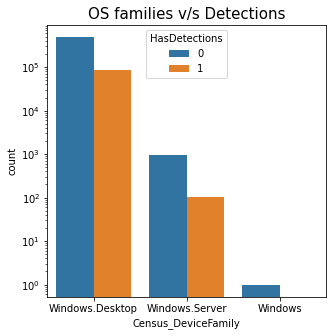

In [24]:
## OS family v/s Detections
plt.figure(figsize = (5,5))
sns.countplot(x='Census_DeviceFamily', hue='HasDetections', data = train)
plt.yscale('log')
plt.title('OS families v/s Detections', size=15)
plt.show()

The graph seems to agree with our previous reasoning that server OS silghtly have better protection

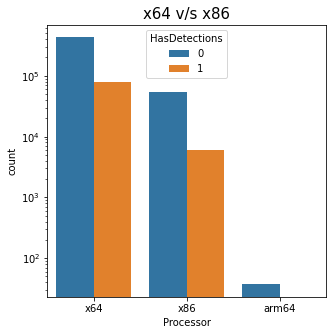

In [25]:
## processor architecture v/s no of Detections
plt.figure(figsize = (5,5))
sns.countplot(x='Processor', hue='HasDetections', data = train)
plt.yscale('log')
plt.title('x64 v/s x86', size=15)
plt.show()

Both architecture seems to have alomst same infection ratio. By intiution x64 should perform better because its modern and would have better defence strategies against malwares. 

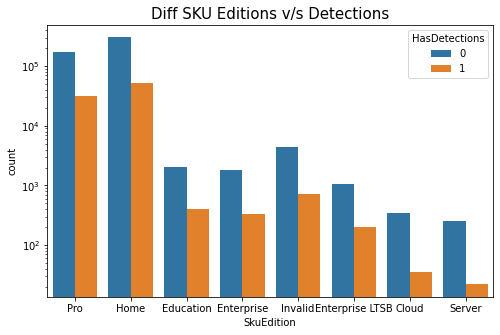

In [26]:
## Diff SKU - Editions (OS usage category) v/s Detections
plt.figure(figsize = (8,5))
sns.countplot(x='SkuEdition', hue='HasDetections', data = train)
plt.yscale('log')
plt.title('Diff SKU Editions v/s Detections', size=15)
plt.show()

Server & Cloud Editions seems to have better defence against malwares, reasoning can be that they are constantly updates with latest security patches and have better maintaince and infrastructure.

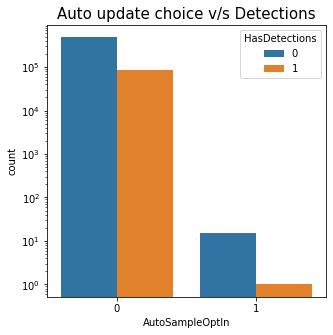

In [27]:
## Auto - updates opt in v/s Detections
plt.figure(figsize = (5,5))
sns.countplot(x='AutoSampleOptIn', hue='HasDetections', data = train)
plt.yscale('log')
plt.title('Auto update choice v/s Detections', size=15)
plt.show()

As expected, most people have turned this feature off, but for those who have this option enabled, they seems to have better protection against malwares.

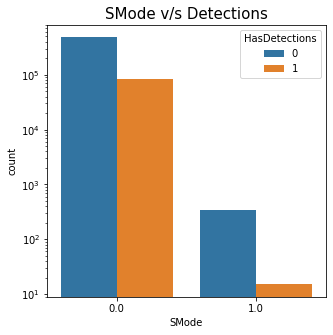

In [28]:
## PUA Mode v/s Detections
plt.figure(figsize = (5,5))
sns.countplot(x='SMode', hue='HasDetections', data = train)
plt.yscale('log')
plt.title('SMode v/s Detections', size=15)
plt.show()

SMode refers to option of having softwares downloaded only from official microsoft store. Hence for those with this option enabled, obviously they have less chance of getting malwares as compared to illegal sources.

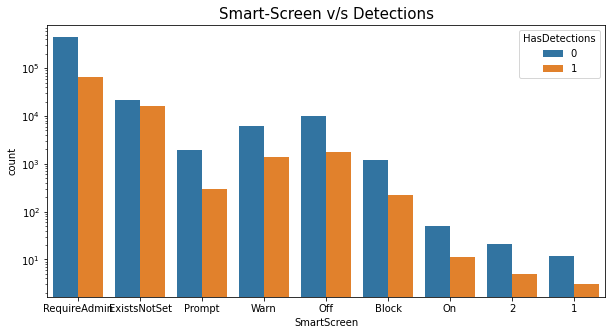

In [29]:
## Smart screen options v/s Detections
plt.figure(figsize = (10,5))
sns.countplot(x='SmartScreen', hue='HasDetections', data = train)
plt.yscale('log')
plt.title('Smart-Screen v/s Detections', size=15)
plt.show()

Smart-screen is primarily made to protect users from malwares, but here most options seems to have same infection rate.

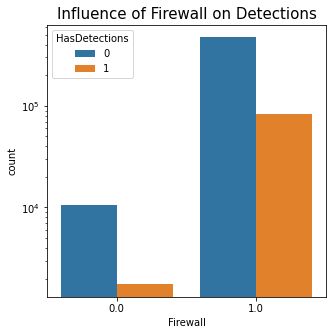

In [30]:
## Firewall options v/s Infections
plt.figure(figsize = (5,5))
sns.countplot(x='Firewall', hue='HasDetections', data = train)
plt.yscale('log')
plt.title('Influence of Firewall on Detections', size=15)
plt.show()

This result goes against common intituion that firewall would protect against malwares. Here firewall off has slightly better infection ratio, but most people have kept firewall turned on in their systems.

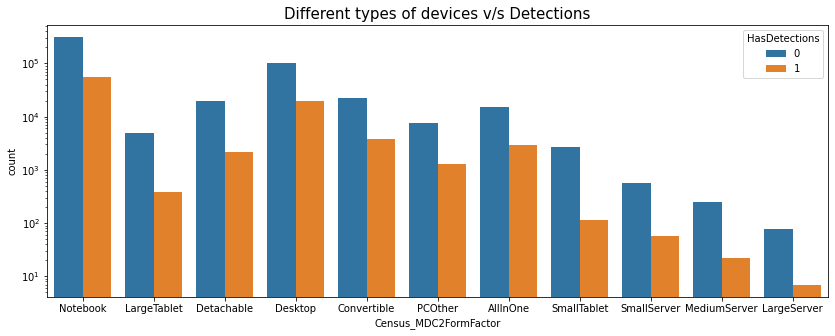

In [31]:
## Diff types of devices v/s Detections
plt.figure(figsize = (14,5))
sns.countplot(x='Census_MDC2FormFactor', hue='HasDetections', data = train)
plt.yscale('log')
plt.title('Different types of devices v/s Detections', size=15)
plt.show()

Here tablet and server devices seems to have better protection against malwares. It can be reasoned that these devices have different OS from traditional PCs hence its PC malwares cant infect them.

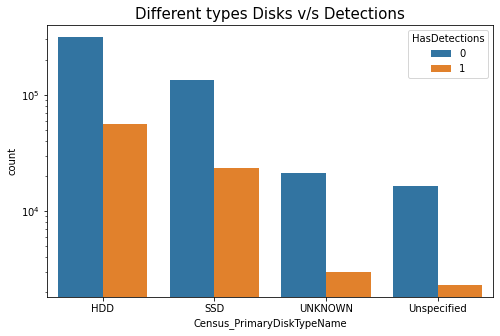

In [32]:
## Diff Disks v/s Detections
plt.figure(figsize = (8,5))
sns.countplot(x='Census_PrimaryDiskTypeName', hue='HasDetections', data = train)
plt.yscale('log')
plt.title('Different types Disks v/s Detections', size=15)
plt.show()

There doesn't seem to have much difference between HDD & SDD Systems. We can club Unknown & Unspecified into single value. 

In [9]:
conversion_dict = {
    'UNKNOWN': 'unknown', 'Unspecified': 'unknown'
}
train.replace({'Census_PrimaryDiskTypeName': conversion_dict}, inplace=True)
test.replace({'Census_PrimaryDiskTypeName': conversion_dict}, inplace=True)

Similarly for Census_PowerPlatfrom, and MDC2 Form factor, we shall club similar values into ones so that it becomes easy for learning algorithm.

In [10]:
conversion_dict = {
    'AppliancePC' : 'AppliancePC', 'Desktop' : 'Desktop', 'EnterpriseServer' : 'EnterpriseServer', 
    'Mobile' : 'Mobile', 'SOHOServer' : 'SOHOServer','Slate' : 'Slate', 'Workstation' : 'Workstation', 
    'PerformanceServer' : 'PerformanceServer', 'UNKNOWN': 'UNKNOWN', 'Unspecified': 'UNKNOWN'
}
train.replace({'Census_PowerPlatformRoleName': conversion_dict}, inplace=True)
test.replace({'Census_PowerPlatformRoleName': conversion_dict}, inplace=True)

conversion_dict = {
    'AllInOne' : 'AllInOne', 'Convertible' : 'Convertible', 'Desktop' :  'Desktop', 'Detachable' : 'Detachable', 
    'LargeServer' : 'Server','LargeTablet' : 'Tablet', 'MediumServer' : 'Server', 'Notebook' : 'Notebook', 
    'PCOther' : 'PCOther', 'SmallServer' : 'Server','SmallTablet' : 'Tablet'
}
train.replace({'Census_MDC2FormFactor': conversion_dict}, inplace=True)
test.replace({'Census_MDC2FormFactor': conversion_dict}, inplace=True)

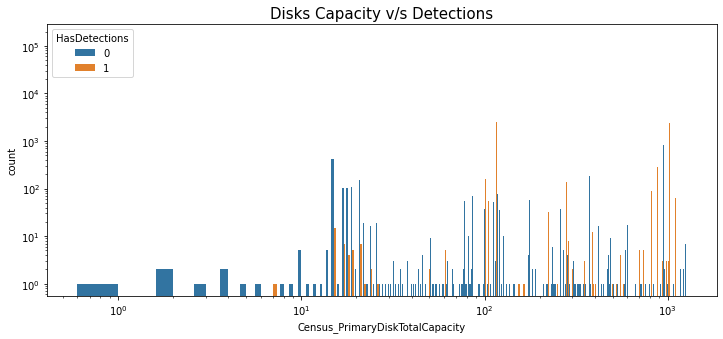

In [35]:
plt.figure(figsize = (12,5))
sns.countplot(x='Census_PrimaryDiskTotalCapacity', hue='HasDetections', data = train)
plt.yscale('log')
plt.xscale('log')
plt.title('Disks Capacity v/s Detections', size=15)
plt.show()

System with Larger size disks have more infections. This can be reasoned as - the more the disk space, the user uses more internet/downloading/softwares, hence he is more prone to get malware

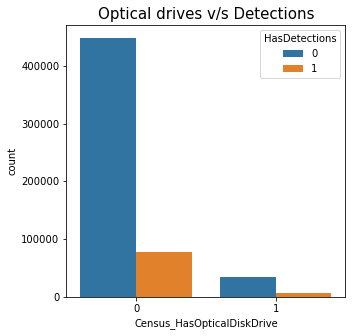

In [36]:
plt.figure(figsize = (5,5))
sns.countplot(x='Census_HasOpticalDiskDrive', hue='HasDetections', data = train)
plt.title('Optical drives v/s Detections', size=15)
plt.show()

Systems without optical drives have better infection protection. This feature may seem it has no effect on malwares, but indirectly systems which have optical drives mean older devices, hence they are more prone to malware attacks. <br>
Similarly all these Census System hardware resource info may not have direct impact on malware infections. But they tell important info on what type of system it is, like whether its old or modern. Based on that the ML algorithm can get vital insight into the type/generation of system and prone it is against malware attacks.

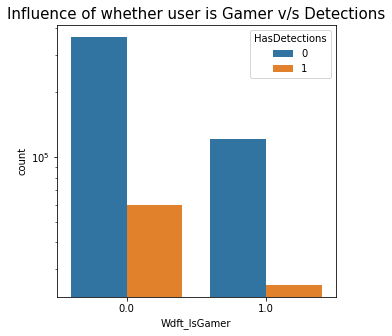

In [37]:
plt.figure(figsize = (5,5))
sns.countplot(x='Wdft_IsGamer', hue='HasDetections', data = train)
plt.yscale('log')
plt.title('Influence of whether user is Gamer v/s Detections', size=15)
plt.show()

This feature is important because if the user is Gamer, he downloads more software, and is connected to internet more often, hence he is more prone to malware attacks. This also agrees with above graph that Gamers are more prone to attacks.

In [38]:
train['IsBeta'].value_counts()

0    567726
1         4
Name: IsBeta, dtype: int64

There are too few softwares in Beta version, hence this feature is useless. We can drop this from train & test datasets.

In [11]:
train.drop('IsBeta', axis=1, inplace=True)
test.drop('IsBeta', axis=1, inplace=True)

### Skew Analysis

Skew parameter of each feature column:

In [40]:
sk = pd.DataFrame([{'column': c, 'skew': train[c].value_counts(normalize=True).values[0] * 100} for c in train.columns])
sk.sort_values(by='skew', ascending=False).head(20)

,column,skew
74,Census_IsWIMBootEnabled,100.000000
27,PuaMode,100.000000
67,Census_IsFlightingInternal,99.999824
68,Census_IsFlightsDisabled,99.998207
26,AutoSampleOptIn,99.997182
70,Census_ThresholdOptIn,99.990488
64,Census_IsPortableOperatingSystem,99.953323
28,SMode,99.935885
34,Census_DeviceFamily,99.815053
32,UacLuaenable,99.402533


As we can see some features are have very large skewness. Some of them have almost 99% skew in them, meanining almost all values are of only few categories. This high skew features won't help much for learning algorithm since it won't add much info to learning. Hence, we shall drop these skewed columns (skew > 99%) from dataset. 

In [12]:
skewed_features = ["Census_IsWIMBootEnabled", "Census_IsFlightingInternal", "Census_ThresholdOptIn", 
                   "Census_IsPortableOperatingSystem", "SMode", "Census_DeviceFamily", "UacLuaenable", 
                   "Census_IsVirtualDevice", "ProductName", "PuaMode"]
train.drop(skewed_features, axis=1, inplace=True)
test.drop(skewed_features, axis=1, inplace=True)

### Feature Engineering

We are combining some features into new columns for sake of simplicity, to add / extract more meaningful info from existing features into new ones. And also to reduce dimensionality of the dataset. <br>
i) We are subtracting System Volume Capacity from Total Disk capacity to make a new feature named "disk_remaining". <br>
ii) We are combining RAM size and Processor count to new feature - "ram_cpu_ratio". <br>
iii) New feature "PPI" by combining Display resolution Horizontal and Vertical sizes. <br>
iv) "aspect_ratio" by dividing Horizontal and Verical Display sizes. <br>
v) "Pixel count" by mulitplying Horizontal and vertical display sizes. 


In [13]:
def additional_features(train,test):
    
    # Disk Space Remaining
    train['disk_remain'] = train['Census_PrimaryDiskTotalCapacity'] - train['Census_SystemVolumeTotalCapacity']
    test['disk_remain'] = test['Census_PrimaryDiskTotalCapacity'] - test['Census_SystemVolumeTotalCapacity']
    train['disk_remain'] = train['disk_remain'].astype('float32')
    test['disk_remain'] = test['disk_remain'].astype('float32')

    # Ram-to-CPU ratio
    train['ram_cpu_ratio'] = train['Census_TotalPhysicalRAM'] / train['Census_ProcessorCoreCount']
    test['ram_cpu_ratio'] = test['Census_TotalPhysicalRAM'] / test['Census_ProcessorCoreCount']

    # Pixel Per Inch PPI sqrt(horizonal**2 + vertical**2) / diagonal
    train['ppi'] = np.sqrt(train['Census_InternalPrimaryDisplayResolutionHorizontal']**2 + train['Census_InternalPrimaryDisplayResolutionVertical']**2) / train['Census_InternalPrimaryDiagonalDisplaySizeInInches']
    test['ppi'] = np.sqrt(test['Census_InternalPrimaryDisplayResolutionHorizontal']**2 + test['Census_InternalPrimaryDisplayResolutionVertical']**2) / test['Census_InternalPrimaryDiagonalDisplaySizeInInches']

    # Screen aspect ratio = Horizonal / Vertical
    train['aspect_ratio'] = train['Census_InternalPrimaryDisplayResolutionHorizontal'] / train['Census_InternalPrimaryDisplayResolutionVertical']
    test['aspect_ratio'] = test['Census_InternalPrimaryDisplayResolutionHorizontal'] / test['Census_InternalPrimaryDisplayResolutionVertical']

    # Pixel count = Horizonal * Vertical
    train['pixel_count'] = train['Census_InternalPrimaryDisplayResolutionHorizontal'] * train['Census_InternalPrimaryDisplayResolutionVertical']
    test['pixel_count'] = test['Census_InternalPrimaryDisplayResolutionHorizontal'] * test['Census_InternalPrimaryDisplayResolutionVertical']
    
    return train, test

In [14]:
## adding new features to both test and train datasets.
train, test = additional_features(train, test)

In [15]:
## deleting redundant columns which we already used for making new features
train.drop('Census_PrimaryDiskTotalCapacity', axis=1, inplace=True)
test.drop('Census_PrimaryDiskTotalCapacity', axis=1, inplace=True)
train.drop('Census_ProcessorClass',inplace=True, axis=1)
test.drop('Census_ProcessorClass', inplace=True, axis=1)

In [16]:
## dropping machine identifier fromt test data since it is also dropped from train dataset and its a string value which makes no sense for algorithm
test.drop('MachineIdentifier', axis=1, inplace=True)

Census_Chassis_Type contains vague values, and by common intiution it doesn't seem to matter for malware detection. Hence we will drop this from both train and test datasets. OS_version feature is repeated twice, hence we will drop on of them.

In [17]:
train.drop('Census_ChassisTypeName',  axis=1, inplace=True)
test.drop('Census_ChassisTypeName',  axis=1, inplace=True)
## OS_Ver are repeated
train.drop('Census_OSVersion',  axis=1, inplace=True)
test.drop('Census_OSVersion',  axis=1, inplace=True)

#### Checking Correaltion of numerical features

Grouping columns into small sets of 20 features each for correlation analysis

In [18]:
cols = train.columns.tolist()

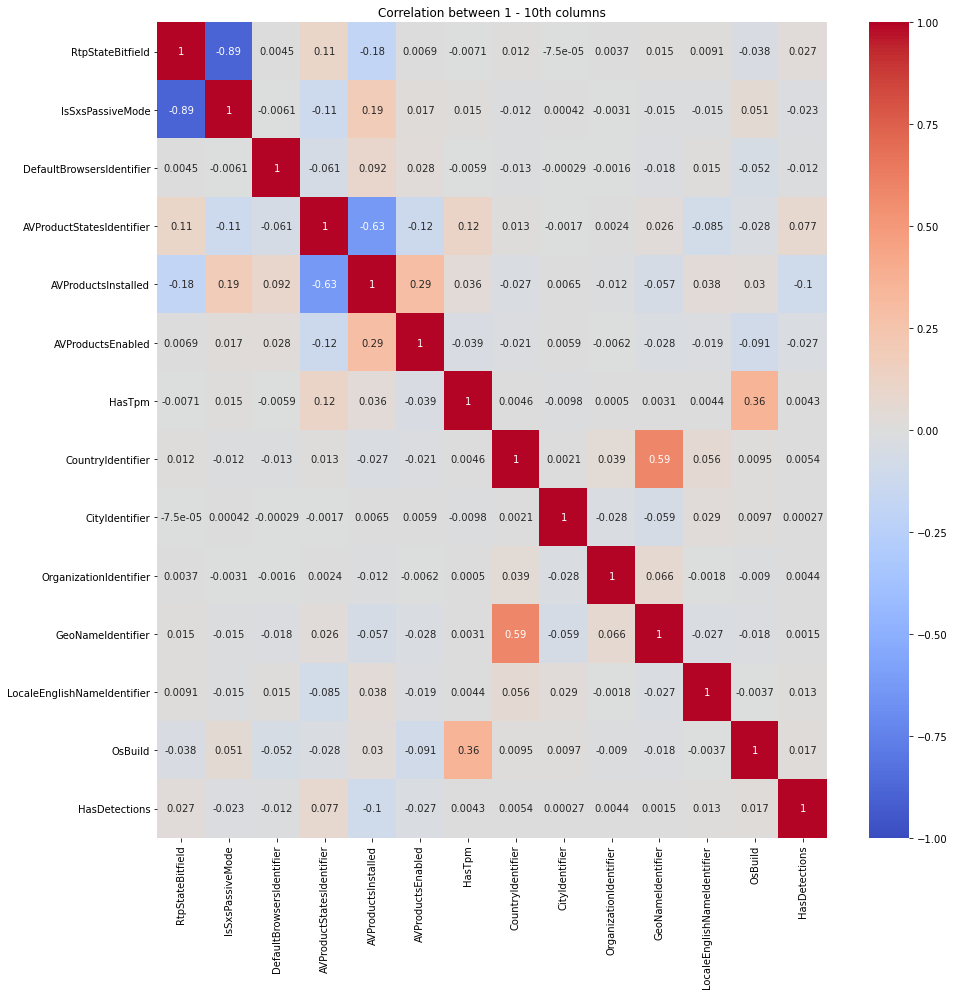

In [48]:
## correlation between first 20 features & target detection column
plt.figure(figsize=(15,15))
cols_1_20 = cols[:20]
cols_1_20.append('HasDetections')
sns.heatmap(train[cols_1_20].corr(), vmin=-1, cmap="coolwarm", annot=True)
plt.title('Correlation between 1 - 10th columns')
plt.show()

Features "RtpStateBitField" and "IsSXSPassiveMode" have relatively high correlation (-0.89). It is to be noted here that these two are negatively correlated. We shall drop feature which has less unique values among these two.

In [49]:
print("Unique values in RtpStateBitfield: ", train.RtpStateBitfield.nunique())
print("Unique values in IsSxsPassiveMode: ", train.IsSxsPassiveMode.nunique())

Unique values in RtpStateBitfield:  6
Unique values in IsSxsPassiveMode:  2


In [19]:
train.drop('IsSxsPassiveMode', axis=1, inplace=True)
test.drop('IsSxsPassiveMode', axis=1, inplace=True)

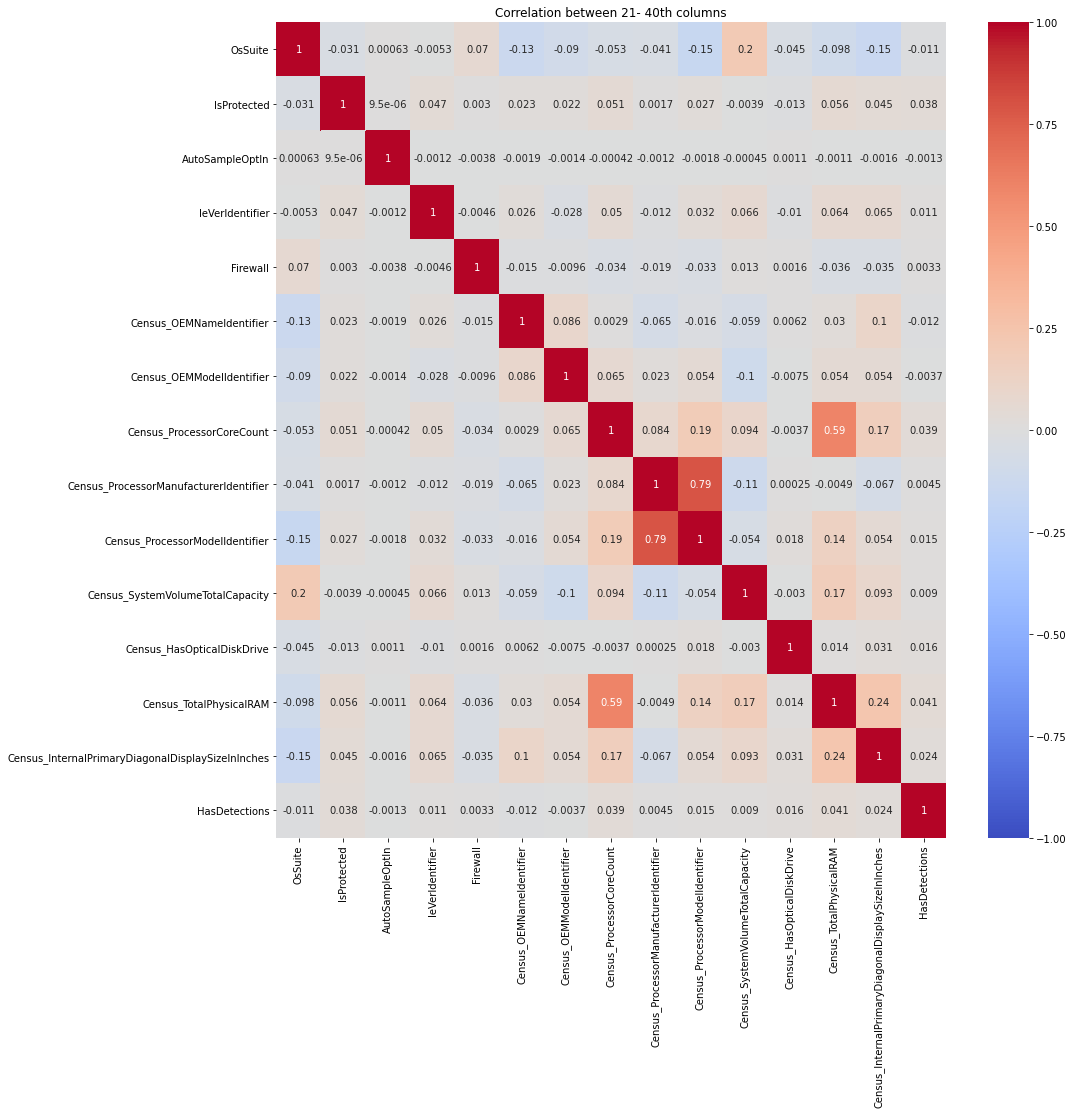

In [51]:
## correlation between 21-40 features & target detection column
plt.figure(figsize=(15,15))
cols_21_40 = cols[20:40]
cols_21_40.append('HasDetections')
sns.heatmap(train[cols_21_40].corr(), vmin=-1, cmap="coolwarm", annot=True)
plt.title('Correlation between 21- 40th columns')
plt.show()

There's slight correlation between "Processor model identifier" & "Processor manufacturer identifier". And also they seem to have similar meaning, hence we shall drop one of them from datasets. Similarly for Sytem Volume Capacity & Primary Disk Capacity.

In [20]:
train.drop('Census_ProcessorManufacturerIdentifier', axis=1, inplace=True)
test.drop('Census_ProcessorManufacturerIdentifier', axis=1, inplace=True)

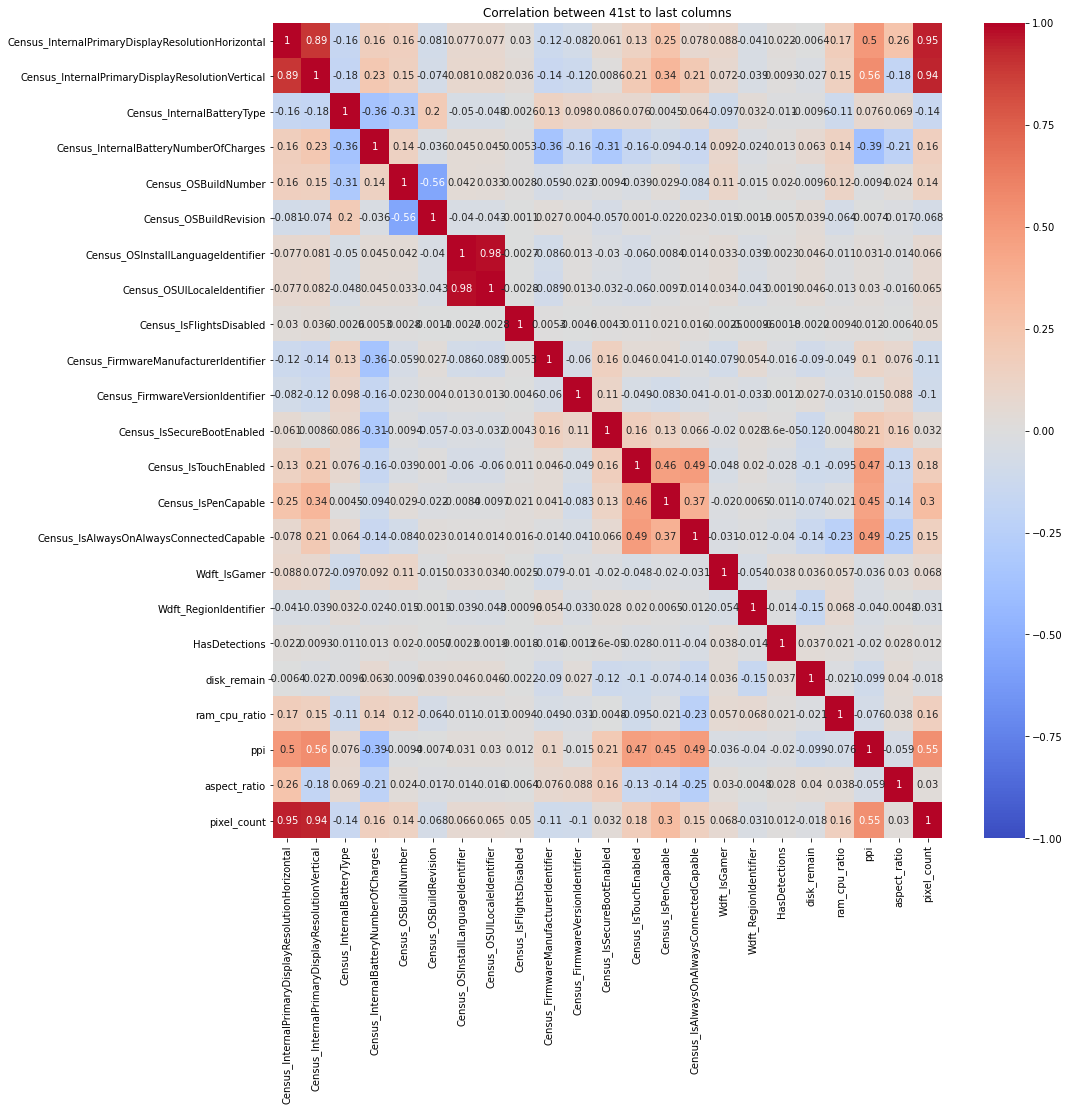

In [53]:
## correlation between 41 to last feature & target detection column
plt.figure(figsize=(15,15))
cols_41_last = cols[40:]
sns.heatmap(train[cols_41_last].corr(), vmin=-1, cmap="coolwarm", annot=True)
plt.title('Correlation between 41st to last columns')
plt.show()

There's high correlation between feature "Vertical Resolution of display" & "Horizontal Resolution of display". We will remove one which has less unique values. Similarly Features "Census_OSUILocaleIdentifier" & "Census_OSInstallLanguageIdentifier" are almost perfectly correlated (corr = 0.98). Here the latter column has less unique values, so it makes sense to drop the column

In [21]:
train.drop('Census_InternalPrimaryDisplayResolutionVertical', axis=1, inplace=True)
test.drop('Census_InternalPrimaryDisplayResolutionVertical', axis=1, inplace=True)
train.drop('Census_OSInstallLanguageIdentifier', axis=1, inplace=True)
test.drop('Census_OSInstallLanguageIdentifier', axis=1, inplace=True)

Before going to encoding cateogorical features, we shall remove some deundant columns still remaining (those having large null values, redundant info etc)

In [22]:
## redundant features (which doesnt give much info shown by EDA Analysis) 
train = train.drop([
            'MachineIdentifier', 
            'CityIdentifier', 
            'AutoSampleOptIn', 
            'Census_InternalBatteryType', 
            'Census_InternalBatteryNumberOfCharges', 
            'Census_OSArchitecture',
            'Census_OSSkuName',
            'Census_IsFlightsDisabled'], axis=1)
test = test.drop([ 
            'CityIdentifier', 
            'AutoSampleOptIn', 
            'Census_InternalBatteryType', 
            'Census_InternalBatteryNumberOfCharges', 
            'Census_OSArchitecture',
            'Census_OSSkuName',
            'Census_IsFlightsDisabled'], axis=1)

#### Categorical Features Encoding

For converting categorical values into numerical, we will be using Frequency encoding, which gives numnerical value according to frequency(no of times) the particular value occurs in the column. some other features we will also be using Label Encoding.

In [23]:
## Feature encoding of categorical columns
frequency_encoded = ['OsPlatformSubRelease', 'OsBuildLab', 'Processor', 'SkuEdition', 'SmartScreen', 'Platform']

def frequency_encoding(variable):
    t = pd.concat([train[variable], test[variable]]).value_counts().reset_index()
    t = t.reset_index()
    t.loc[t[variable] == 1, 'level_0'] = np.nan
    t.set_index('index', inplace=True)
    max_label = t['level_0'].max() + 1
    t.fillna(max_label, inplace=True)
    return t.to_dict()['level_0']

for variable in frequency_encoded:
    freq_enc_dict = frequency_encoding(variable)
    train[variable] = train[variable].map(lambda x: freq_enc_dict.get(x, np.nan))
    test[variable] = test[variable].map(lambda x: freq_enc_dict.get(x, np.nan))

In [24]:
## Label Encoding
## Label Encoding of remaining Census categorical columns

from sklearn.preprocessing import LabelEncoder
feature_encoded = ['Census_MDC2FormFactor', 'Census_PrimaryDiskTypeName', 'Census_PowerPlatformRoleName', 'Census_OSBranch', 'Census_OSEdition', 
                   'Census_OSInstallTypeName', 'Census_OSWUAutoUpdateOptionsName', 'Census_GenuineStateName', 'Census_ActivationChannel', 
                   'Census_FlightRing', 'EngineVersion', 'AppVersion', 'AvSigVersion', 'OsVer']
for feature in feature_encoded:
    train[feature] = LabelEncoder().fit_transform(train[feature])
    test[feature] = LabelEncoder().fit_transform(test[feature])

### Applying Training Algorithm

We tried several learning algorithm for this problem such as SVM (with rbf, linear kernel), Logistic Regression, Naive Bayes classifier, Random forest ensembles etc. <br>We also did SMOTE Oversampling for increasing datapoints for minority class. This method gave better performance for SVM and Logistic Regression, but not for Naive Bayes and Ensemble models like Random Forest.
Of all the models tried, LGBM got the best AUC metric score for this dataset. <br> We did not do SMOTE Oversampling here because we tried it on previous ensemble models and found that ensembles handle unbalanced datasets on thier own and won't perform marginally better by oversampling methods.

Here we are applying Light Gradient Boosted Tree learning algorithm for following reasons: <br>
i) Its a tree based learning classification algorithm <br>
ii) Faster training speed and higher efficiency <br>
iii) Lower memory usage. <br>
iv) Better accuracy. <br>
v) Support of parallel and GPU learning <br>
vi) Capable of handling large-scale data

In [34]:
train_db = train.copy()
test_db = test.copy()
target = train_db['HasDetections']
train_db.drop('HasDetections', axis=1, inplace=True)

In [35]:
## splitting of train, test datasets into validation sets
from sklearn import model_selection
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = model_selection.train_test_split(train_db, target, test_size = .15, random_state = 1)

Here we are using Optuna library for tuning hyperparameters 

In [44]:
## using optuna for tuning hyper-parameters
import optuna.integration.lightgbm as lgbm
dtrain = lgbm.Dataset(x_train, label=y_train)
dval = lgbm.Dataset(x_val, label=y_val)

params = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
    }

In [45]:
## finding best possible combination of hype-rprameters
model = lgbm.train(params, dtrain, valid_sets=[dtrain, dval], verbose_eval=100, early_stopping_rounds = 5)

prediction = np.rint(model.predict(x_val, num_iteration = model.best_iteration))
accuracy = accuracy_score(y_val, prediction)

[I 2020-11-30 10:23:28,028] A new study created in memory with name: no-name-51f54f19-620f-424a-b00d-bc9b1d709188
feature_fraction, val_score: -inf:   0%|                                                         | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.719327	valid_1's auc: 0.70998
[200]	valid_0's auc: 0.734883	valid_1's auc: 0.712586


feature_fraction, val_score: 0.713148:  14%|######4                                      | 1/7 [00:21<02:10, 21.77s/it]

Early stopping, best iteration is:
[218]	valid_0's auc: 0.737418	valid_1's auc: 0.713148
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.720928	valid_1's auc: 0.707866


feature_fraction, val_score: 0.713148:  29%|############8                                | 2/7 [00:33<01:34, 18.82s/it]

Early stopping, best iteration is:
[116]	valid_0's auc: 0.724146	valid_1's auc: 0.708628
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.720298	valid_1's auc: 0.710297


feature_fraction, val_score: 0.713148:  43%|###################2                         | 3/7 [00:54<01:17, 19.36s/it]

Early stopping, best iteration is:
[185]	valid_0's auc: 0.733837	valid_1's auc: 0.712856
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.72038	valid_1's auc: 0.708846
[200]	valid_0's auc: 0.737305	valid_1's auc: 0.711668


feature_fraction, val_score: 0.713148:  57%|#########################7                   | 4/7 [01:15<00:59, 19.82s/it]

Early stopping, best iteration is:
[203]	valid_0's auc: 0.737755	valid_1's auc: 0.711771
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.720514	valid_1's auc: 0.708789


feature_fraction, val_score: 0.713148:  71%|################################1            | 5/7 [01:26<00:34, 17.37s/it]

Early stopping, best iteration is:
[122]	valid_0's auc: 0.724699	valid_1's auc: 0.709851
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.721097	valid_1's auc: 0.708562


feature_fraction, val_score: 0.713148:  86%|######################################5      | 6/7 [01:38<00:15, 15.65s/it]

Early stopping, best iteration is:
[123]	valid_0's auc: 0.725613	valid_1's auc: 0.709527
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.720274	valid_1's auc: 0.70961


num_leaves, val_score: 0.713148:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[143]	valid_0's auc: 0.727788	valid_1's auc: 0.711123
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.738143	valid_1's auc: 0.713671


num_leaves, val_score: 0.713708:   5%|##5                                               | 1/20 [00:11<03:39, 11.58s/it]

Early stopping, best iteration is:
[99]	valid_0's auc: 0.737828	valid_1's auc: 0.713708
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.76149	valid_1's auc: 0.715397


num_leaves, val_score: 0.715474:  10%|#####                                             | 2/20 [00:24<03:34, 11.94s/it]

Early stopping, best iteration is:
[107]	valid_0's auc: 0.763902	valid_1's auc: 0.715474
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.744555	valid_1's auc: 0.714454


num_leaves, val_score: 0.715474:  15%|#######5                                          | 3/20 [00:37<03:30, 12.40s/it]

Early stopping, best iteration is:
[121]	valid_0's auc: 0.750573	valid_1's auc: 0.715155
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.803382	valid_1's auc: 0.7147


num_leaves, val_score: 0.715474:  20%|##########                                        | 4/20 [00:51<03:24, 12.76s/it]

Early stopping, best iteration is:
[101]	valid_0's auc: 0.804221	valid_1's auc: 0.714769
Training until validation scores don't improve for 5 rounds


num_leaves, val_score: 0.715474:  25%|############5                                     | 5/20 [01:03<03:07, 12.51s/it]

Early stopping, best iteration is:
[93]	valid_0's auc: 0.759094	valid_1's auc: 0.714408
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.710741	valid_1's auc: 0.705984


num_leaves, val_score: 0.715474:  30%|###############                                   | 6/20 [01:18<03:08, 13.44s/it]

Early stopping, best iteration is:
[170]	valid_0's auc: 0.719344	valid_1's auc: 0.709241
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.768414	valid_1's auc: 0.714442


num_leaves, val_score: 0.715474:  35%|#################5                                | 7/20 [01:31<02:51, 13.17s/it]

Early stopping, best iteration is:
[102]	valid_0's auc: 0.769302	valid_1's auc: 0.714489
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.761024	valid_1's auc: 0.714506


num_leaves, val_score: 0.715474:  40%|####################                              | 8/20 [01:44<02:35, 12.97s/it]

Early stopping, best iteration is:
[101]	valid_0's auc: 0.761594	valid_1's auc: 0.714597
Training until validation scores don't improve for 5 rounds


num_leaves, val_score: 0.715474:  45%|######################5                           | 9/20 [01:56<02:21, 12.86s/it]

Early stopping, best iteration is:
[93]	valid_0's auc: 0.784128	valid_1's auc: 0.714276
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.734452	valid_1's auc: 0.713532


num_leaves, val_score: 0.715474:  50%|########################5                        | 10/20 [02:09<02:09, 12.90s/it]

Early stopping, best iteration is:
[119]	valid_0's auc: 0.739291	valid_1's auc: 0.714052
Training until validation scores don't improve for 5 rounds


num_leaves, val_score: 0.715474:  55%|##########################9                      | 11/20 [02:21<01:52, 12.50s/it]

[100]	valid_0's auc: 0.74485	valid_1's auc: 0.714609
Early stopping, best iteration is:
[95]	valid_0's auc: 0.743132	valid_1's auc: 0.714688
Training until validation scores don't improve for 5 rounds


num_leaves, val_score: 0.715476:  60%|#############################4                   | 12/20 [02:33<01:40, 12.50s/it]

[100]	valid_0's auc: 0.779066	valid_1's auc: 0.71532
Early stopping, best iteration is:
[95]	valid_0's auc: 0.776351	valid_1's auc: 0.715476
Training until validation scores don't improve for 5 rounds


num_leaves, val_score: 0.715476:  65%|###############################8                 | 13/20 [02:45<01:26, 12.38s/it]

Early stopping, best iteration is:
[91]	valid_0's auc: 0.775701	valid_1's auc: 0.71499
Training until validation scores don't improve for 5 rounds


num_leaves, val_score: 0.715476:  70%|##################################3              | 14/20 [02:57<01:13, 12.31s/it]

Early stopping, best iteration is:
[86]	valid_0's auc: 0.784464	valid_1's auc: 0.715092
Training until validation scores don't improve for 5 rounds


num_leaves, val_score: 0.715476:  75%|####################################7            | 15/20 [03:10<01:02, 12.44s/it]

Early stopping, best iteration is:
[92]	valid_0's auc: 0.769918	valid_1's auc: 0.714287
Training until validation scores don't improve for 5 rounds


num_leaves, val_score: 0.715476:  80%|#######################################2         | 16/20 [03:23<00:50, 12.61s/it]

Early stopping, best iteration is:
[91]	valid_0's auc: 0.74737	valid_1's auc: 0.714131
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.713502	valid_1's auc: 0.707598


num_leaves, val_score: 0.715476:  85%|#########################################6       | 17/20 [03:36<00:38, 12.74s/it]

Early stopping, best iteration is:
[131]	valid_0's auc: 0.717732	valid_1's auc: 0.709122
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.756536	valid_1's auc: 0.714962


num_leaves, val_score: 0.715476:  90%|############################################1    | 18/20 [03:49<00:25, 12.80s/it]

Early stopping, best iteration is:
[100]	valid_0's auc: 0.756536	valid_1's auc: 0.714962
Training until validation scores don't improve for 5 rounds


num_leaves, val_score: 0.715476:  95%|##############################################5  | 19/20 [04:02<00:12, 12.90s/it]

Early stopping, best iteration is:
[90]	valid_0's auc: 0.77188	valid_1's auc: 0.71521
Training until validation scores don't improve for 5 rounds


bagging, val_score: 0.715476:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[83]	valid_0's auc: 0.770274	valid_1's auc: 0.71498
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.77918	valid_1's auc: 0.715172
Early stopping, best iteration is:
[96]	valid_0's auc: 0.776782	valid_1's auc: 0.715346


bagging, val_score: 0.715476:  10%|#####3                                               | 1/10 [00:12<01:54, 12.75s/it]

Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.779033	valid_1's auc: 0.715754


bagging, val_score: 0.715754:  20%|##########6                                          | 2/10 [00:27<01:46, 13.32s/it]

Early stopping, best iteration is:
[100]	valid_0's auc: 0.779033	valid_1's auc: 0.715754
Training until validation scores don't improve for 5 rounds


bagging, val_score: 0.715754:  30%|###############9                                     | 3/10 [00:39<01:30, 12.98s/it]

Early stopping, best iteration is:
[64]	valid_0's auc: 0.752051	valid_1's auc: 0.706407
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.778388	valid_1's auc: 0.714728


bagging, val_score: 0.715754:  40%|#####################2                               | 4/10 [00:57<01:25, 14.33s/it]

Early stopping, best iteration is:
[98]	valid_0's auc: 0.777322	valid_1's auc: 0.714873
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.778923	valid_1's auc: 0.715847
Early stopping, best iteration is:
[97]	valid_0's auc: 0.777177	valid_1's auc: 0.715853


bagging, val_score: 0.715853:  50%|##########################5                          | 5/10 [01:12<01:12, 14.58s/it]

Training until validation scores don't improve for 5 rounds


bagging, val_score: 0.715853:  60%|###############################8                     | 6/10 [01:29<01:01, 15.30s/it]

Early stopping, best iteration is:
[91]	valid_0's auc: 0.773642	valid_1's auc: 0.714959
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.777835	valid_1's auc: 0.714974


bagging, val_score: 0.715853:  70%|#####################################                | 7/10 [01:44<00:45, 15.30s/it]

Early stopping, best iteration is:
[100]	valid_0's auc: 0.777835	valid_1's auc: 0.714974
Training until validation scores don't improve for 5 rounds


bagging, val_score: 0.715853:  80%|##########################################4          | 8/10 [02:00<00:30, 15.44s/it]

Early stopping, best iteration is:
[86]	valid_0's auc: 0.77011	valid_1's auc: 0.71378
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.775172	valid_1's auc: 0.710379


bagging, val_score: 0.715853:  90%|###############################################7     | 9/10 [02:14<00:15, 15.15s/it]

Early stopping, best iteration is:
[103]	valid_0's auc: 0.776976	valid_1's auc: 0.710544
Training until validation scores don't improve for 5 rounds


feature_fraction_stage2, val_score: 0.715853:   0%|                                              | 0/3 [00:00<?, ?it/s]

Early stopping, best iteration is:
[91]	valid_0's auc: 0.77376	valid_1's auc: 0.715039
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.78138	valid_1's auc: 0.713887


feature_fraction_stage2, val_score: 0.715853:  33%|############6                         | 1/3 [00:19<00:38, 19.24s/it]

Early stopping, best iteration is:
[102]	valid_0's auc: 0.78251	valid_1's auc: 0.714035
Training until validation scores don't improve for 5 rounds


feature_fraction_stage2, val_score: 0.715853:  67%|#########################3            | 2/3 [00:34<00:17, 17.93s/it]

Early stopping, best iteration is:
[86]	valid_0's auc: 0.772811	valid_1's auc: 0.714156
Training until validation scores don't improve for 5 rounds


regularization_factors, val_score: 0.715853:   0%|                                              | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[86]	valid_0's auc: 0.771331	valid_1's auc: 0.714757
Training until validation scores don't improve for 5 rounds


regularization_factors, val_score: 0.715857:   5%|#9                                    | 1/20 [00:15<04:56, 15.61s/it]

Early stopping, best iteration is:
[90]	valid_0's auc: 0.769824	valid_1's auc: 0.715857
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.763804	valid_1's auc: 0.716902


regularization_factors, val_score: 0.718061:  10%|###8                                  | 2/20 [00:38<05:18, 17.71s/it]

Early stopping, best iteration is:
[147]	valid_0's auc: 0.780762	valid_1's auc: 0.718061
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.759325	valid_1's auc: 0.716978


regularization_factors, val_score: 0.718061:  15%|#####7                                | 3/20 [00:56<05:04, 17.92s/it]

Early stopping, best iteration is:
[111]	valid_0's auc: 0.7635	valid_1's auc: 0.717446
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.76616	valid_1's auc: 0.717073


regularization_factors, val_score: 0.718061:  20%|#######6                              | 4/20 [01:15<04:52, 18.28s/it]

Early stopping, best iteration is:
[109]	valid_0's auc: 0.769973	valid_1's auc: 0.717428
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.762055	valid_1's auc: 0.716566


regularization_factors, val_score: 0.718061:  25%|#########5                            | 5/20 [01:35<04:41, 18.75s/it]

Early stopping, best iteration is:
[111]	valid_0's auc: 0.766365	valid_1's auc: 0.717015
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.759989	valid_1's auc: 0.716882


regularization_factors, val_score: 0.718061:  30%|###########4                          | 6/20 [01:53<04:20, 18.62s/it]

Early stopping, best iteration is:
[114]	valid_0's auc: 0.765288	valid_1's auc: 0.717289
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.758491	valid_1's auc: 0.716366


regularization_factors, val_score: 0.718061:  35%|#############3                        | 7/20 [02:13<04:05, 18.91s/it]

Early stopping, best iteration is:
[122]	valid_0's auc: 0.766362	valid_1's auc: 0.717265
Training until validation scores don't improve for 5 rounds


regularization_factors, val_score: 0.718061:  40%|###############2                      | 8/20 [02:30<03:38, 18.23s/it]

Early stopping, best iteration is:
[90]	valid_0's auc: 0.756512	valid_1's auc: 0.716362
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.757927	valid_1's auc: 0.716558


regularization_factors, val_score: 0.718061:  45%|#################1                    | 9/20 [02:53<03:37, 19.77s/it]

Early stopping, best iteration is:
[131]	valid_0's auc: 0.768495	valid_1's auc: 0.717852
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.759808	valid_1's auc: 0.716733


regularization_factors, val_score: 0.718061:  50%|##################5                  | 10/20 [03:20<03:38, 21.87s/it]

Early stopping, best iteration is:
[151]	valid_0's auc: 0.777312	valid_1's auc: 0.718035


[I 2020-11-30 10:36:20,887] Trial 49 finished with value: 0.718035198147016 and parameters: {'lambda_l1': 8.444801260811733, 'lambda_l2': 1.0776242877550437e-05}. Best is trial 41 with value: 0.7180611974431843.
regularization_factors, val_score: 0.718061:  50%|##################5                  | 10/20 [03:20<03:38, 21.87s/it]

Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.778923	valid_1's auc: 0.715847
Early stopping, best iteration is:
[97]	valid_0's auc: 0.777177	valid_1's auc: 0.715853

regularization_factors, val_score: 0.718061:  55%|####################3                | 11/20 [03:36<03:00, 20.11s/it]


Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.758812	valid_1's auc: 0.716069


regularization_factors, val_score: 0.718061:  60%|######################2              | 12/20 [03:57<02:42, 20.31s/it]

Early stopping, best iteration is:
[106]	valid_0's auc: 0.76123	valid_1's auc: 0.716529
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.760024	valid_1's auc: 0.716468


regularization_factors, val_score: 0.718061:  65%|########################             | 13/20 [04:14<02:17, 19.58s/it]

Early stopping, best iteration is:
[108]	valid_0's auc: 0.763271	valid_1's auc: 0.716873
Training until validation scores don't improve for 5 rounds


regularization_factors, val_score: 0.718061:  70%|#########################9           | 14/20 [04:31<01:51, 18.65s/it]

Early stopping, best iteration is:
[91]	valid_0's auc: 0.773165	valid_1's auc: 0.715764
Training until validation scores don't improve for 5 rounds


regularization_factors, val_score: 0.718061:  75%|###########################7         | 15/20 [04:47<01:29, 17.88s/it]

Early stopping, best iteration is:
[91]	valid_0's auc: 0.773108	valid_1's auc: 0.715526
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.760508	valid_1's auc: 0.716463


regularization_factors, val_score: 0.718061:  80%|#############################6       | 16/20 [05:10<01:17, 19.41s/it]

Early stopping, best iteration is:
[126]	valid_0's auc: 0.769968	valid_1's auc: 0.717254
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.771159	valid_1's auc: 0.716913


regularization_factors, val_score: 0.718061:  85%|###############################4     | 17/20 [05:28<00:57, 19.08s/it]

Early stopping, best iteration is:
[101]	valid_0's auc: 0.771702	valid_1's auc: 0.71699
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.757582	valid_1's auc: 0.716359


regularization_factors, val_score: 0.718061:  90%|#################################3   | 18/20 [05:51<00:40, 20.02s/it]

Early stopping, best iteration is:
[129]	valid_0's auc: 0.767306	valid_1's auc: 0.717141
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.776089	valid_1's auc: 0.71597


regularization_factors, val_score: 0.718061:  95%|###################################1 | 19/20 [06:10<00:19, 19.96s/it]

Early stopping, best iteration is:
[125]	valid_0's auc: 0.788312	valid_1's auc: 0.716544
Training until validation scores don't improve for 5 rounds


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Early stopping, best iteration is:
[87]	valid_0's auc: 0.771784	valid_1's auc: 0.715483


min_data_in_leaf, val_score: 0.718061:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.764031	valid_1's auc: 0.716748


min_data_in_leaf, val_score: 0.718061:  20%|#########                                    | 1/5 [00:23<01:32, 23.04s/it]

Early stopping, best iteration is:
[146]	valid_0's auc: 0.780548	valid_1's auc: 0.717899
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.763659	valid_1's auc: 0.716281


min_data_in_leaf, val_score: 0.718061:  40%|##################                           | 2/5 [00:45<01:08, 22.72s/it]

Early stopping, best iteration is:
[128]	valid_0's auc: 0.773985	valid_1's auc: 0.717322
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.763662	valid_1's auc: 0.716697


min_data_in_leaf, val_score: 0.718106:  60%|###########################                  | 3/5 [01:08<00:46, 23.06s/it]

Early stopping, best iteration is:
[145]	valid_0's auc: 0.78003	valid_1's auc: 0.718106


[I 2020-11-30 10:40:36,305] Trial 62 finished with value: 0.7181057010682349 and parameters: {'min_child_samples': 25}. Best is trial 62 with value: 0.7181057010682349.
min_data_in_leaf, val_score: 0.718106:  60%|###########################                  | 3/5 [01:08<00:46, 23.06s/it]

Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.763707	valid_1's auc: 0.716933


min_data_in_leaf, val_score: 0.718220:  80%|####################################         | 4/5 [01:33<00:23, 23.68s/it]

Early stopping, best iteration is:
[147]	valid_0's auc: 0.780746	valid_1's auc: 0.71822
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.763792	valid_1's auc: 0.716865


min_data_in_leaf, val_score: 0.718220: 100%|#############################################| 5/5 [01:53<00:00, 22.77s/it]

Early stopping, best iteration is:
[111]	valid_0's auc: 0.768018	valid_1's auc: 0.717248


In [46]:
## best hyper-parameters

best_params = model.params
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

  Params: 
    objective: binary
    metric: auc
    verbosity: -1
    boosting_type: gbdt
    feature_pre_filter: False
    lambda_l1: 5.857587469644338
    lambda_l2: 1.3714452722008635e-05
    num_leaves: 163
    feature_fraction: 0.4
    bagging_fraction: 0.9953148479721977
    bagging_freq: 1
    min_child_samples: 10
    num_iterations: 1000
    early_stopping_round: 5


In [47]:
## training model using best obtained (tuned) hyper-parameters
model = lgbm.train(best_params, dtrain, 10000, valid_sets=[dtrain, dval], early_stopping_rounds=500, verbose_eval=100)

[I 2020-11-30 10:43:22,476] A new study created in memory with name: no-name-5944fe3a-b5f1-4bd2-8bd5-834103abd298
feature_fraction, val_score: -inf:   0%|                                                         | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.76875	valid_1's auc: 0.71577


feature_fraction, val_score: 0.715865:  14%|######4                                      | 1/7 [00:15<01:31, 15.18s/it]

Early stopping, best iteration is:
[102]	valid_0's auc: 0.769532	valid_1's auc: 0.715865
Training until validation scores don't improve for 5 rounds


feature_fraction, val_score: 0.716734:  29%|############8                                | 2/7 [00:28<01:13, 14.75s/it]

Early stopping, best iteration is:
[85]	valid_0's auc: 0.760889	valid_1's auc: 0.716734
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.769784	valid_1's auc: 0.716082


feature_fraction, val_score: 0.716734:  43%|###################2                         | 3/7 [00:44<00:59, 14.90s/it]

Early stopping, best iteration is:
[100]	valid_0's auc: 0.769784	valid_1's auc: 0.716082
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.763707	valid_1's auc: 0.716933


feature_fraction, val_score: 0.718220:  57%|#########################7                   | 4/7 [01:08<00:53, 17.82s/it]

Early stopping, best iteration is:
[147]	valid_0's auc: 0.780746	valid_1's auc: 0.71822
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.770804	valid_1's auc: 0.715196


feature_fraction, val_score: 0.718220:  71%|################################1            | 5/7 [01:27<00:36, 18.05s/it]

Early stopping, best iteration is:
[99]	valid_0's auc: 0.770288	valid_1's auc: 0.715225
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.769596	valid_1's auc: 0.714575


feature_fraction, val_score: 0.718220:  86%|######################################5      | 6/7 [01:48<00:18, 18.91s/it]

Early stopping, best iteration is:
[128]	valid_0's auc: 0.782195	valid_1's auc: 0.715309
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.765482	valid_1's auc: 0.716233


num_leaves, val_score: 0.718220:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[111]	valid_0's auc: 0.770013	valid_1's auc: 0.716543
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.749162	valid_1's auc: 0.716909


num_leaves, val_score: 0.718220:   5%|##5                                               | 1/20 [00:18<05:56, 18.74s/it]

Early stopping, best iteration is:
[111]	valid_0's auc: 0.752592	valid_1's auc: 0.717335
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.758648	valid_1's auc: 0.716884


num_leaves, val_score: 0.718220:  10%|#####                                             | 2/20 [00:39<05:48, 19.35s/it]

Early stopping, best iteration is:
[111]	valid_0's auc: 0.762793	valid_1's auc: 0.717195
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.770102	valid_1's auc: 0.717251


num_leaves, val_score: 0.718220:  15%|#######5                                          | 3/20 [01:02<05:44, 20.29s/it]

Early stopping, best iteration is:
[114]	valid_0's auc: 0.776117	valid_1's auc: 0.717781
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.69766	valid_1's auc: 0.696981
[200]	valid_0's auc: 0.705473	valid_1's auc: 0.702669
[300]	valid_0's auc: 0.7104	valid_1's auc: 0.705833
[400]	valid_0's auc: 0.714596	valid_1's auc: 0.708344


num_leaves, val_score: 0.718220:  20%|##########                                        | 4/20 [01:44<07:10, 26.90s/it]

Early stopping, best iteration is:
[448]	valid_0's auc: 0.716352	valid_1's auc: 0.709306
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.785451	valid_1's auc: 0.716897


num_leaves, val_score: 0.718220:  25%|############5                                     | 5/20 [02:03<06:10, 24.69s/it]

Early stopping, best iteration is:
[112]	valid_0's auc: 0.791898	valid_1's auc: 0.717237
Training until validation scores don't improve for 5 rounds


num_leaves, val_score: 0.718220:  30%|###############                                   | 6/20 [02:19<05:07, 21.94s/it]

Early stopping, best iteration is:
[88]	valid_0's auc: 0.772472	valid_1's auc: 0.716249
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.768167	valid_1's auc: 0.716704


num_leaves, val_score: 0.718220:  35%|#################5                                | 7/20 [02:39<04:39, 21.47s/it]

Early stopping, best iteration is:
[148]	valid_0's auc: 0.785873	valid_1's auc: 0.718066
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.736587	valid_1's auc: 0.715362
[200]	valid_0's auc: 0.757032	valid_1's auc: 0.717408


num_leaves, val_score: 0.718220:  40%|####################                              | 8/20 [03:07<04:41, 23.46s/it]

Early stopping, best iteration is:
[241]	valid_0's auc: 0.764234	valid_1's auc: 0.717923
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.767762	valid_1's auc: 0.717147


num_leaves, val_score: 0.718220:  45%|######################5                           | 9/20 [03:24<03:56, 21.47s/it]

Early stopping, best iteration is:
[104]	valid_0's auc: 0.76941	valid_1's auc: 0.71717
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.732925	valid_1's auc: 0.71437


num_leaves, val_score: 0.718220:  50%|########################5                        | 10/20 [03:44<03:30, 21.01s/it]

Early stopping, best iteration is:
[159]	valid_0's auc: 0.744686	valid_1's auc: 0.716303
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.782702	valid_1's auc: 0.716998


num_leaves, val_score: 0.718220:  55%|##########################9                      | 11/20 [04:02<03:00, 20.10s/it]

Early stopping, best iteration is:
[106]	valid_0's auc: 0.785841	valid_1's auc: 0.717157
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.77217	valid_1's auc: 0.716589


num_leaves, val_score: 0.718220:  60%|#############################4                   | 12/20 [04:22<02:41, 20.14s/it]

Early stopping, best iteration is:
[128]	valid_0's auc: 0.783403	valid_1's auc: 0.717744
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.75707	valid_1's auc: 0.71644


num_leaves, val_score: 0.718220:  65%|###############################8                 | 13/20 [04:37<02:09, 18.44s/it]

Early stopping, best iteration is:
[102]	valid_0's auc: 0.757824	valid_1's auc: 0.716558
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.742358	valid_1's auc: 0.716695


num_leaves, val_score: 0.718220:  70%|##################################3              | 14/20 [04:55<01:50, 18.49s/it]

Early stopping, best iteration is:
[130]	valid_0's auc: 0.750087	valid_1's auc: 0.717793
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.71976	valid_1's auc: 0.711081
[200]	valid_0's auc: 0.733591	valid_1's auc: 0.714987


num_leaves, val_score: 0.718220:  75%|####################################7            | 15/20 [05:20<01:41, 20.32s/it]

Early stopping, best iteration is:
[219]	valid_0's auc: 0.735646	valid_1's auc: 0.715438
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.736402	valid_1's auc: 0.715401


num_leaves, val_score: 0.718220:  80%|#######################################2         | 16/20 [05:41<01:22, 20.62s/it]

Early stopping, best iteration is:
[174]	valid_0's auc: 0.752005	valid_1's auc: 0.717134
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.76531	valid_1's auc: 0.7168


num_leaves, val_score: 0.718220:  85%|#########################################6       | 17/20 [05:58<00:58, 19.36s/it]

Early stopping, best iteration is:
[105]	valid_0's auc: 0.767476	valid_1's auc: 0.717012
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.751034	valid_1's auc: 0.716732


num_leaves, val_score: 0.718355:  90%|############################################1    | 18/20 [06:19<00:39, 19.88s/it]

Early stopping, best iteration is:
[147]	valid_0's auc: 0.76544	valid_1's auc: 0.718355
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.750841	valid_1's auc: 0.716664


num_leaves, val_score: 0.718355:  95%|##############################################5  | 19/20 [06:38<00:19, 19.63s/it]

Early stopping, best iteration is:
[136]	valid_0's auc: 0.761607	valid_1's auc: 0.717935
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.76077	valid_1's auc: 0.716674


bagging, val_score: 0.718355:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[131]	valid_0's auc: 0.772097	valid_1's auc: 0.717816
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.748692	valid_1's auc: 0.714423
Early stopping, best iteration is:
[96]	valid_0's auc: 0.747297	valid_1's auc: 0.71452


bagging, val_score: 0.718355:  10%|#####3                                               | 1/10 [00:14<02:13, 14.82s/it]

Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.751312	valid_1's auc: 0.715875


bagging, val_score: 0.718355:  20%|##########6                                          | 2/10 [00:30<02:00, 15.03s/it]

Early stopping, best iteration is:
[111]	valid_0's auc: 0.754704	valid_1's auc: 0.716508
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.744377	valid_1's auc: 0.709793


bagging, val_score: 0.718355:  30%|###############9                                     | 3/10 [00:42<01:39, 14.26s/it]

Early stopping, best iteration is:
[101]	valid_0's auc: 0.744725	valid_1's auc: 0.709824
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.751375	valid_1's auc: 0.716098


bagging, val_score: 0.718355:  40%|#####################2                               | 4/10 [01:02<01:36, 16.03s/it]

Early stopping, best iteration is:
[136]	valid_0's auc: 0.762529	valid_1's auc: 0.717121
Training until validation scores don't improve for 5 rounds


bagging, val_score: 0.718355:  50%|##########################5                          | 5/10 [01:12<01:09, 13.99s/it]

Early stopping, best iteration is:
[51]	valid_0's auc: 0.727975	valid_1's auc: 0.70739
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.749813	valid_1's auc: 0.714721


bagging, val_score: 0.718355:  60%|###############################8                     | 6/10 [01:34<01:06, 16.50s/it]

Early stopping, best iteration is:
[130]	valid_0's auc: 0.759681	valid_1's auc: 0.715814
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.750343	valid_1's auc: 0.714841


bagging, val_score: 0.718355:  70%|#####################################                | 7/10 [01:55<00:53, 17.81s/it]

Early stopping, best iteration is:
[118]	valid_0's auc: 0.756335	valid_1's auc: 0.71545
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.74796	valid_1's auc: 0.713856


bagging, val_score: 0.718355:  80%|##########################################4          | 8/10 [02:09<00:33, 16.57s/it]

Early stopping, best iteration is:
[100]	valid_0's auc: 0.74796	valid_1's auc: 0.713856
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.750293	valid_1's auc: 0.71525


bagging, val_score: 0.718355:  90%|###############################################7     | 9/10 [02:25<00:16, 16.65s/it]

Early stopping, best iteration is:
[105]	valid_0's auc: 0.752061	valid_1's auc: 0.715536
Training until validation scores don't improve for 5 rounds


feature_fraction_stage2, val_score: 0.718355:   0%|                                              | 0/3 [00:00<?, ?it/s]

Early stopping, best iteration is:
[94]	valid_0's auc: 0.745422	valid_1's auc: 0.712049
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.751542	valid_1's auc: 0.716586


feature_fraction_stage2, val_score: 0.718355:  33%|############6                         | 1/3 [00:19<00:39, 19.69s/it]

Early stopping, best iteration is:
[145]	valid_0's auc: 0.765377	valid_1's auc: 0.718101
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.752003	valid_1's auc: 0.717151


feature_fraction_stage2, val_score: 0.718355:  67%|#########################3            | 2/3 [00:35<00:18, 18.49s/it]

Early stopping, best iteration is:
[107]	valid_0's auc: 0.754337	valid_1's auc: 0.717493
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.752989	valid_1's auc: 0.715763


regularization_factors, val_score: 0.718355:   0%|                                              | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[102]	valid_0's auc: 0.753623	valid_1's auc: 0.71583
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.762942	valid_1's auc: 0.714654


regularization_factors, val_score: 0.718355:   5%|#9                                    | 1/20 [00:14<04:39, 14.70s/it]

Early stopping, best iteration is:
[106]	valid_0's auc: 0.765541	valid_1's auc: 0.714918
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.762843	valid_1's auc: 0.714761


regularization_factors, val_score: 0.718355:  10%|###8                                  | 2/20 [00:27<04:14, 14.14s/it]

Early stopping, best iteration is:
[98]	valid_0's auc: 0.761966	valid_1's auc: 0.71479
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.749777	valid_1's auc: 0.716375


regularization_factors, val_score: 0.718355:  15%|#####7                                | 3/20 [00:46<04:26, 15.67s/it]

Early stopping, best iteration is:
[129]	valid_0's auc: 0.75815	valid_1's auc: 0.717583
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.762843	valid_1's auc: 0.714761


regularization_factors, val_score: 0.718355:  20%|#######6                              | 4/20 [01:00<04:01, 15.06s/it]

Early stopping, best iteration is:
[98]	valid_0's auc: 0.761966	valid_1's auc: 0.71479
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.74875	valid_1's auc: 0.716377


regularization_factors, val_score: 0.718355:  25%|#########5                            | 5/20 [01:17<03:55, 15.70s/it]

Early stopping, best iteration is:
[109]	valid_0's auc: 0.751542	valid_1's auc: 0.716758
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.752945	valid_1's auc: 0.716367


regularization_factors, val_score: 0.718355:  30%|###########4                          | 6/20 [01:34<03:46, 16.20s/it]

Early stopping, best iteration is:
[122]	valid_0's auc: 0.759361	valid_1's auc: 0.716957
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.762843	valid_1's auc: 0.714754


regularization_factors, val_score: 0.718355:  35%|#############3                        | 7/20 [01:49<03:22, 15.58s/it]

Early stopping, best iteration is:
[98]	valid_0's auc: 0.761967	valid_1's auc: 0.714783
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.762328	valid_1's auc: 0.715101


regularization_factors, val_score: 0.718355:  40%|###############2                      | 8/20 [02:04<03:04, 15.41s/it]

Early stopping, best iteration is:
[101]	valid_0's auc: 0.762805	valid_1's auc: 0.715125
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.762843	valid_1's auc: 0.714762


regularization_factors, val_score: 0.718355:  45%|#################1                    | 9/20 [02:17<02:44, 14.92s/it]

Early stopping, best iteration is:
[98]	valid_0's auc: 0.761966	valid_1's auc: 0.71479
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.759975	valid_1's auc: 0.715923


regularization_factors, val_score: 0.718355:  50%|##################5                  | 10/20 [02:33<02:30, 15.07s/it]

Early stopping, best iteration is:
[107]	valid_0's auc: 0.76241	valid_1's auc: 0.716221
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.76315	valid_1's auc: 0.715061


regularization_factors, val_score: 0.718355:  55%|####################3                | 11/20 [02:46<02:10, 14.51s/it]

Early stopping, best iteration is:
[98]	valid_0's auc: 0.762137	valid_1's auc: 0.715177
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.763018	valid_1's auc: 0.714451


regularization_factors, val_score: 0.718355:  60%|######################2              | 12/20 [02:59<01:53, 14.17s/it]

Early stopping, best iteration is:
[101]	valid_0's auc: 0.763456	valid_1's auc: 0.714463
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.762843	valid_1's auc: 0.714761


regularization_factors, val_score: 0.718355:  65%|########################             | 13/20 [03:12<01:36, 13.82s/it]

Early stopping, best iteration is:
[98]	valid_0's auc: 0.761966	valid_1's auc: 0.71479
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.762508	valid_1's auc: 0.71527


regularization_factors, val_score: 0.718355:  70%|#########################9           | 14/20 [03:28<01:25, 14.25s/it]

Early stopping, best iteration is:
[118]	valid_0's auc: 0.770185	valid_1's auc: 0.715783
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.762899	valid_1's auc: 0.714216


regularization_factors, val_score: 0.718355:  75%|###########################7         | 15/20 [03:41<01:09, 13.93s/it]

Early stopping, best iteration is:
[101]	valid_0's auc: 0.763374	valid_1's auc: 0.714242
Training until validation scores don't improve for 5 rounds


regularization_factors, val_score: 0.718355:  80%|#############################6       | 16/20 [03:54<00:54, 13.69s/it]

Early stopping, best iteration is:
[87]	valid_0's auc: 0.756982	valid_1's auc: 0.714059
Training until validation scores don't improve for 5 rounds


regularization_factors, val_score: 0.718355:  85%|###############################4     | 17/20 [04:07<00:40, 13.43s/it]

Early stopping, best iteration is:
[88]	valid_0's auc: 0.753981	valid_1's auc: 0.715834
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.763488	valid_1's auc: 0.714442


regularization_factors, val_score: 0.718355:  90%|#################################3   | 18/20 [04:22<00:27, 13.92s/it]

Early stopping, best iteration is:
[107]	valid_0's auc: 0.766328	valid_1's auc: 0.714682
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.756984	valid_1's auc: 0.715945


regularization_factors, val_score: 0.718355:  95%|###################################1 | 19/20 [04:37<00:14, 14.42s/it]

Early stopping, best iteration is:
[118]	valid_0's auc: 0.763401	valid_1's auc: 0.716291
Training until validation scores don't improve for 5 rounds


min_data_in_leaf, val_score: 0.718355:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Early stopping, best iteration is:
[91]	valid_0's auc: 0.757968	valid_1's auc: 0.713874
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.751034	valid_1's auc: 0.716732


min_data_in_leaf, val_score: 0.718355:  20%|#########                                    | 1/5 [00:19<01:17, 19.45s/it]

Early stopping, best iteration is:
[147]	valid_0's auc: 0.76544	valid_1's auc: 0.718355
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.751034	valid_1's auc: 0.716732


min_data_in_leaf, val_score: 0.718355:  40%|##################                           | 2/5 [00:38<00:57, 19.21s/it]

Early stopping, best iteration is:
[147]	valid_0's auc: 0.76544	valid_1's auc: 0.718355
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.751034	valid_1's auc: 0.716732


min_data_in_leaf, val_score: 0.718355:  60%|###########################                  | 3/5 [00:55<00:37, 18.80s/it]

Early stopping, best iteration is:
[147]	valid_0's auc: 0.76544	valid_1's auc: 0.718355
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.751034	valid_1's auc: 0.716732


min_data_in_leaf, val_score: 0.718355:  80%|####################################         | 4/5 [01:16<00:19, 19.21s/it]

Early stopping, best iteration is:
[147]	valid_0's auc: 0.76544	valid_1's auc: 0.718355
Training until validation scores don't improve for 5 rounds
[100]	valid_0's auc: 0.751034	valid_1's auc: 0.716732


min_data_in_leaf, val_score: 0.718355: 100%|#############################################| 5/5 [01:37<00:00, 19.44s/it]

Early stopping, best iteration is:
[147]	valid_0's auc: 0.76544	valid_1's auc: 0.718355


In [48]:
## predicting with best iteration score obtained above
result = model.predict(test_db, num_iteration = model.best_iteration)

In [49]:
## saving prediction results to csv file
df = pd.DataFrame(result)
res = pd.concat([machine_id, df], axis = 1)
res.set_index('MachineIdentifier',inplace=True)
res.columns = {'HasDetections'}
res.to_csv('submission_kaggle.csv')